In [29]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [30]:
# load data
apple_df = pd.read_csv('/Users/anujthakkar/Documents/Purdue/Projects/Stock Market/flask_app/data/clean/AAPL_feature_engineered.csv')
#apple_df = apple_df.sort_values(by='Date', ascending=True).reset_index(drop=True)
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    2517 non-null   object 
 1   Close                   2517 non-null   float64
 2   Volume                  2517 non-null   float64
 3   Open                    2517 non-null   float64
 4   High                    2517 non-null   float64
 5   Low                     2517 non-null   float64
 6   Daily_Return            2517 non-null   float64
 7   5_day_mean_close_price  2517 non-null   float64
 8   5_day_mean_volume       2517 non-null   float64
 9   Daily_Range             2517 non-null   float64
 10  Volatility              2517 non-null   float64
 11  Quarter                 2517 non-null   object 
 12  EMA_Close_5             2517 non-null   float64
 13  EMA_Close_20            2517 non-null   float64
dtypes: float64(12), object(2)
memory usage: 

In [31]:
# Define the features and target variables
target = ['Close']

# Define the features
features = apple_df.drop(['Close', 'Date', 'Quarter'], axis=1).columns.tolist()

# Create arrays for the features and the response variable
X = apple_df[features].values
y = apple_df[target].values
print("X and y shapes:", X.shape, y.shape)


# Apply scaling to the target variable 'y' (Close prices)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)

print(apple_df.columns.tolist())


# Split the dataset into training and test sets: 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, shuffle=False)

# Print the first and last dates in the training set
train_dates = pd.to_datetime(apple_df['Date']).iloc[:len(X_train)]
print("Training set starts from:", train_dates.iloc[0])
print("Training set ends at:", train_dates.iloc[-1])


# Print the first and last dates in the test set
test_dates = pd.to_datetime(apple_df['Date']).iloc[-len(X_test):]
print("Test set starts from:", test_dates.iloc[0])
print("Test set ends at:", test_dates.iloc[-1])


X and y shapes: (2517, 11) (2517, 1)
['Date', 'Close', 'Volume', 'Open', 'High', 'Low', 'Daily_Return', '5_day_mean_close_price', '5_day_mean_volume', 'Daily_Range', 'Volatility', 'Quarter', 'EMA_Close_5', 'EMA_Close_20']
Training set starts from: 2013-07-23 00:00:00
Training set ends at: 2021-07-20 00:00:00
Test set starts from: 2021-07-21 00:00:00
Test set ends at: 2023-07-21 00:00:00


In [32]:
# LSTM expects input in the form of [samples, time steps, features] - 3D tensor (3D array) 

# 1 time step (previous day's data) for each sample
time_steps = 1 

print(X_train.shape)
print(X_test.shape)
X_train_lstm = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# avoid this error ==> ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
X_train_lstm = X_train_lstm.astype('float32')
X_test_lstm = X_test_lstm.astype('float32')

print(X_train_lstm.shape)
print(X_test_lstm.shape)
print()

(2013, 11)
(504, 11)
(2013, 1, 11)
(504, 1, 11)



In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Initialize the LSTM model
model = Sequential()

# Add the LSTM layer with 50 units and input shape (time_steps, features)
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))

# Add a Dense layer to output the predicted value
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
# Train the model on the training data
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=5, verbose=1, shuffle=False)


Epoch 1/100
403/403 [==============================] - 2s 1ms/step - loss: 0.1482
Epoch 2/100
403/403 [==============================] - 0s 1ms/step - loss: 0.0535
Epoch 3/100
403/403 [==============================] - 1s 1ms/step - loss: 0.0115
Epoch 4/100
403/403 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 5/100
403/403 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 6/100
403/403 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 7/100
403/403 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 8/100
403/403 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 9/100
403/403 [==============================] - 0s 1ms/step - loss: 7.9338e-04
Epoch 10/100
403/403 [==============================] - 0s 1ms/step - loss: 5.8086e-04
Epoch 11/100
403/403 [==============================] - 0s 1ms/step - loss: 4.2998e-04
Epoch 12/100
403/403 [==============================] - 1s 1ms/step - loss: 3.4014e-

In [35]:
#LSTM Prediction
y_pred_scaled = model.predict(X_test_lstm)

# Inverse scaling the predictions and true values for visualization
y_pred_original = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test)

16/16 [==============================] - 0s 902us/step


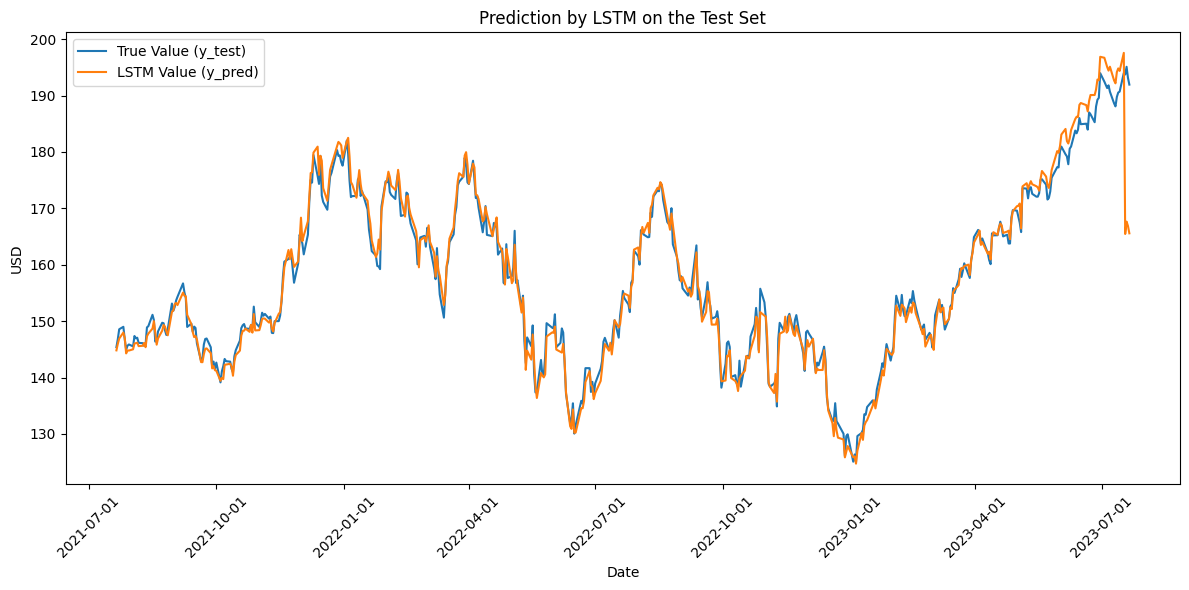

In [36]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Extract the dates for plotting
dates = pd.to_datetime(apple_df['Date']).iloc[-len(y_test_original):]  # Dates corresponding to the test set

# Plot the results with adjusted intervals on the x-axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, y_test_original, label='True Value (y_test)')
ax.plot(dates, y_pred_original, label='LSTM Value (y_pred)')
ax.set_title('Prediction by LSTM on the Test Set')
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax.legend()

# Format the x-axis date intervals to show approximately 20 date labels
interval = len(dates) // 20
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()